In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#Import basic libraries
%matplotlib inline


import os
import sys
import init
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from django_pandas.io import read_frame
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

from matplotlib.dates import date2num

#Prepare to load stock data as pandas dataframe from source. In this case, prepare django
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

from stocks.models import Listing, Stock, Market

#Import TA-lib and backtesting library
import talib
from talib.abstract import *
from talib import MA_Type

from backtesting import Strategy
from backtesting import Backtest
from backtesting.lib import crossover

/mnt/c/Users/anshu/Documents/experimental/env/lib/python3.8/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [99]:
#Load Nifty data
df = pd.read_csv('./NIFTY50.csv', index_col=0)
#df = pd.read_csv('./NIFTY50.csv')
for column in df.columns:
    if column != 'date':
       df[column] = pd.to_numeric(df[column])
#df['date'] = pd.to_datetime(df['date'])
#df['date'] = df['date'].tz_localize(None)
#df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)

df = df.sort_index()
df = df.reindex(columns = ['open', 'high', 'low', 'close', 'volume'])
#df.drop('volume', axis=1, inplace=True)
df.rename(columns={"open": "Open", "high": "High", "low": "Low", "close":"Close", "volume":'Volume'}, inplace=True)

df = df[~df.index.duplicated(keep='first')]

print(df.tail())
#Optionally, filter out by date range
start_date = '2022-02-18 09:15:00'
end_date = '2022-02-18 15:30:00'
df = df.loc[start_date:end_date]
#drop duplicates

                         Open      High       Low     Close  Volume
date                                                               
2022-02-18 15:25:00  17267.90  17276.35  17265.90  17276.35       0
2022-02-18 15:26:00  17276.85  17277.25  17273.40  17274.65       0
2022-02-18 15:27:00  17273.85  17276.25  17272.10  17274.45       0
2022-02-18 15:28:00  17274.60  17274.65  17263.10  17266.00       0
2022-02-18 15:29:00  17265.95  17271.30  17263.65  17268.75       0


In [100]:
from scipy.signal import argrelextrema

def get_max_min(prices, smoothing, window_range):
    #Smoothen prices
    smooth_prices = prices['Close'].rolling(window=smoothing).mean().dropna()
    #Find maximas (single value comprasions, try to use order=n for n range)
    local_max = argrelextrema(data = smooth_prices.values, comparator = np.greater)[0]
    #Find minimas
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    
    
    #Find the index of the first maxima in the window
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i <len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmax())
    
    #Find the index of the first minina in the window
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i <len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmin())
    
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    
    maxima.index.name = 'date'
    maxima = maxima.reset_index()
    maxima = maxima[~maxima.date.duplicated()]
    minima.index.name = 'date'
    minima = minima.reset_index()
    minima = minima[~minima.date.duplicated()]
    
    
    p = prices.reset_index()
    
    #max_min['day_num'] = p[p['date'].isin(max_min.date)].index.values
    max_min = p[p['date'].isin(max_min.date)]
    max_min = max_min.set_index('date')
    max_min['minmax'] = np.nan
    max_min['minmax'] = max_min['minmax'].fillna(max_min['Close'])
    
    maxima = p[p['date'].isin(maxima.date)]
    maxima = maxima.set_index('date')
    maxima['max'] = np.nan
    maxima['max'] = maxima['max'].fillna(maxima['Close'])
    #max_min = max_min.set_index('day_num')['Close']
    minima = p[p['date'].isin(minima.date)]
    minima = minima.set_index('date')
    minima['min'] = np.nan
    minima['min'] = minima['min'].fillna(minima['Close'])

    return [max_min, maxima, minima]

In [107]:
smoothing = 5
window_range = 3
[minmax, maxima, minima] = get_max_min(df, smoothing, window_range)

#Create a dataframe of size original dataframe and populate values of minmax in the respective slots
minmax_df = pd.DataFrame(index=df.index.copy(), columns = ['minmax'])
minmax_df = minmax_df.combine_first(minmax)
minmax_l = minmax_df['minmax'].tolist()
#minmax.head()

#print(minmax['minmax'].tolist())
def isFarFromLevel(l, margin, levels):
  return np.sum([abs(l-x) < margin  for x in levels]) == 0

levels = []
max_levels = []
min_levels = []
margin = 10
for l in minmax['minmax'].tolist():
    if isFarFromLevel(l, margin, levels):
        levels.append(l)
for l in maxima['max'].tolist():
    if isFarFromLevel(l, margin, max_levels):
        max_levels.append(l)
for l in minima['min'].tolist():
    if isFarFromLevel(l, margin, min_levels):
        min_levels.append(l)

[17267.9, 17286.1, 17318.1, 17241.25, 17252.65, 17307.1, 17329.85, 17354.95, 17377.5, 17365.95, 17342.9, 17297.05]


<Mpf_Figure size 1200x1000 with 0 Axes>

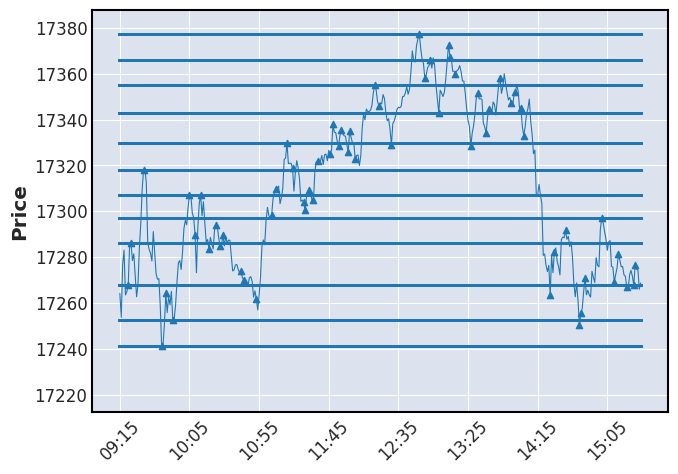

In [108]:
import mplfinance as mpf
fig = mpf.figure(style='yahoo', figsize=(12,10))

print(levels)
ap = [mpf.make_addplot(minmax_l, type='scatter', markersize=20, marker='^'),
      #mpf.make_addplot(levels, type='hlines'),
     ]
mpf.plot(df, hlines=levels, type='line', addplot = ap)

<Mpf_Figure size 2000x1800 with 0 Axes>

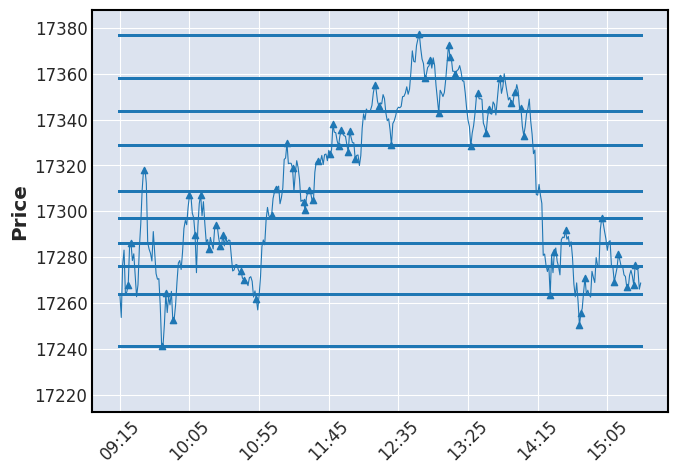

In [109]:
#To reduce noise, we want to group close points together and plot on just one of them (min)
import scipy
import scipy.cluster.hierarchy as sch
from sklearn.cluster import MeanShift, estimate_bandwidth
from numpy import array, linspace
from sklearn.neighbors import KernelDensity

def get_cluster_heads(levels, maxima=True):
    X = np.array([list(a) for a in zip(levels,np.zeros(len(levels)))], dtype=int)
    bandwidth = 0
    quantile = 0.16
    while bandwidth==0 and quantile>0:
        quantile -=0.01
        bandwidth = estimate_bandwidth(X, quantile=quantile)
    
    if bandwidth==0:
        print('Bandwidth too less. Using a small value')
        bandwidth = 0.1
    #print(bandwidth)
    #print(x.reshape(-1, 1))
    #kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x.reshape(-1, 1))
    #s = linspace(0,50)
    #e = kde.score_samples(s.reshape(-1,1))

    #from matplotlib.pyplot import plot
    #plot(s, e)
    #Map the value to its cluster
    #clusters = [ind[i] for i in list((np.argsort(ind)))]
    #values = [minmax['minmax'].tolist()[i] for i in list((np.argsort(ind)))]

    #print(values)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    new_levels = []
    for k in range(n_clusters_):
        my_members = labels == k
        #print ("cluster {0}: {1}".format(k, X[my_members, 0]))
        new_levels.append(float(min(X[my_members, 0])) if maxima is False else float(max(X[my_members, 0])))    
    return new_levels


new_levels = get_cluster_heads(np.array(minmax['minmax'].tolist()))
max_levels = get_cluster_heads(np.array(maxima['max'].tolist()))
min_levels = get_cluster_heads(np.array(minima['min'].tolist()))

final_levels = []
for l in max_levels+min_levels:
    if isFarFromLevel(l, margin, final_levels):
        final_levels.append(l)

fig = mpf.figure(style='yahoo', figsize=(20,18))

ap = [mpf.make_addplot(minmax_l, type='scatter', markersize=20, marker='^'),
      #mpf.make_addplot(levels, type='hlines'),
     ]
mpf.plot(df, hlines=final_levels, type='line', addplot = ap)